In [ ]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV, cross_validate
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, log_loss, confusion_matrix, make_scorer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB, ComplementNB, GaussianNB, BernoulliNB
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, OrdinalEncoder, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from imblearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from matplotlib.gridspec import GridSpec
from sklearn.metrics import roc_curve, RocCurveDisplay, auc, precision_recall_curve

### Obiettivo
L'obiettivo del seguente progetto è creare un classificatore che sia in grado di fornire un'indicazione sull'affidabilità creditizia di nuovi clienti che richiedono la concessione di una carta di credito. In particolare, tale modello sulla base delle informazioni fornite dovrà essere in grado di predire se il soggetto sarà o meno un "Cattivo pagatore" e quindi se concedere o meno la carta di credito.

### Funzioni

Di seguito sono riportate le funzioni utilizzate nel progetto.

In [ ]:
def recall_0(y_true, y_pred):
  #Function to calculate the recall of the class 0
  return recall_score(y_true, y_pred, pos_label=0)

def precision_0(y_true, y_pred):
  #Function to calculate the precision of the class 0
  return precision_score(y_true, y_pred, pos_label=0)

In [ ]:
def get_df_comp_CV(scores,model_params):
  #Function to create a dataframe with the metrics of several models

  df_comp = pd.DataFrame(columns=['accuracy','precision_1','precision_0','recall_1','recall_0','kernel','set'])

  for i in range(len(model_params)):
    list_add = [scores[i]['train_accuracy'].mean(),
                scores[i]['train_precision_1'].mean(),
                scores[i]['train_precision_0'].mean(),
                scores[i]['train_recall_1'].mean(),
                scores[i]['train_recall_0'].mean(),
                model_params[i],
                'Train']
    df_comp.loc[len(df_comp)] = list_add

    list_add = [scores[i]['test_accuracy'].mean(),
                scores[i]['test_precision_1'].mean(),
                scores[i]['test_precision_0'].mean(),
                scores[i]['test_recall_1'].mean(),
                scores[i]['test_recall_0'].mean(),
                model_params[i],
                'Test']
    df_comp.loc[len(df_comp)] = list_add

  return df_comp

In [ ]:
def print_cv_score(score):
  #Function to print the results of the Cross-validation with the metrics in SCORING_CV

  print('TRAIN SET:')
  print(f"Accuracy: {score['train_accuracy'].mean(): .3f}")
  print(f"Precision CLASS 1: {score['train_precision_1'].mean(): .3f}")
  print(f"Precision CLASS 0: {score['train_precision_0'].mean(): .3f}")
  print(f"Recall CLASS 1: {score['train_recall_1'].mean(): .3f}")
  print(f"Recall CLASS 0: {score['train_recall_0'].mean(): .3f}")

  print('\nTEST SET:')
  print(f"Accuracy: {score['test_accuracy'].mean(): .3f}")
  print(f"Precision CLASS 1: {score['test_precision_1'].mean(): .3f}")
  print(f"Precision CLASS 0: {score['test_precision_0'].mean(): .3f}")
  print(f"Recall CLASS 1: {score['test_recall_1'].mean(): .3f}")
  print(f"Recall CLASS 0: {score['test_recall_0'].mean(): .3f}")

In [ ]:
def plot_precision_recall_curve(model, X, y):
  #Plot of the precision-recall curve with AUC

  probs = model.predict_proba(X)[:,1]
  precision, recall, thr = precision_recall_curve(y, probs)
  auc_score = auc(recall, precision)

  plt.plot(recall, precision)
  plt.title('Precision - Recall Curve   AUC: '+str(auc_score))
  plt.xlabel('Recall')
  plt.ylabel('Precision')
  plt.show()


def plot_precision_recall_curve_comp(models, X, y, models_name):
  #Plot of the precision-recall curve with AUC for different models
  plt.figure(figsize = (8,8))
  for i in range(len(models)):

    model = models[i]

    probs = model.predict_proba(X[i])[:,1]
    precision, recall, thr = precision_recall_curve(y[i], probs)
    auc_score = auc(recall, precision)

    plt.plot(recall, precision, label = models_name[i]+' - AUC: '+str(round(auc_score,3)))

  plt.title('Precision - Recall Curve - Model Comparison')
  plt.xlabel('Recall')
  plt.ylabel('Precision')
  plt.legend()
  plt.show()




In [ ]:
def plot_confusion_matrix(y_true, y_predict, labels = ['0','1']):

  #function to plot confusion matrix
  #labels: labels of the target

  cm = confusion_matrix(y_true, y_predict)

  df_cm = pd.DataFrame(cm,
                      index = [labels[0],labels[1]],
                      columns = ['Predicted '+labels[0], 'Predicted '+labels[1]])

  plt.figure()
  sns.heatmap(df_cm, annot = True, fmt = 'g')
  plt.title('CONFUSION MATRIX')
  plt.show()

In [ ]:
def model_prediction(model, X):
  #Function to print model's prediction

  X = pd.DataFrame(X).transpose()
  pred = model.predict(X)
  pred_proba = model.predict_proba(X)

  if pred:
    print(f"L'utente ha una SCARSA AFFIDABILITA' CREDITIZIA con una probabilità del {np.round(pred_proba[:,1],3).item()*100}%")
  else:
    print(f"L'utente ha una BUONA AFFIDABILITA' CREDITIZIA con una probabilità del {np.round(pred_proba[:,0],3).item()*100}%")

### Analisi del Dataset

Il file "application_record.csv" contiene 438557 osservazioni con le informazioni di potenziali clienti, descritte da 18 variabili.

In [ ]:
#CONSTANT

PATH = '/content/drive/MyDrive/MASTER DATA SCIENCE/5 - Machine Learning: modelli e algoritmi/'

SCORING_CV = {'accuracy': 'accuracy',
           'precision_1': 'precision',
           'precision_0':make_scorer(precision_0),
           'recall_1':'recall',
           'recall_0':make_scorer(recall_0)}

In [ ]:
appl = pd.read_csv(PATH+'application_record.csv')

In [ ]:
appl.shape

(438557, 18)

In [ ]:
appl.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0


Nel file "credit_record.csv", invece, è riportato lo Status del debito mensilmente per ciascun ID.

In [ ]:
cred = pd.read_csv(PATH+'credit_record.csv')

In [ ]:
cred.head()

In [ ]:
cred.ID.unique().shape

(45985,)

Come verrà descritto più nel dettaglio in seguito, volendo addestrare un modello di classificazione supervisionato per ciascuna osservazione del file "application_record.csv" utilizzata è nacessario una feauture target che indichi l'affidabilità creditizia.

Per fare ciò sono state utilizzate le informazioni presenti nel file "credit_record.csv"; innanzittuto sono state considerate esclusivamente le osservazioni relative agli ID presenti nel file "application_record.csv".

In [ ]:
cred = cred[cred.ID.isin(appl.ID)] #Join on ID

In [ ]:
cred.ID.unique().shape

(36457,)

La variabile STATUS può assumere le seguenti modalità:
* C: pagamento regolare
* 0: ritardo da 0 a 29 giorni
* 1: ritardo da 30 a 59 giorni
* 2: ritardo da 60 a 89 giorni
* 3: ritardo da 90 a 119 giorni
* 4: ritardo da 120 a 149 giorni
* 5: credito inesegibile
* X: nessun debito per il mese corrente

La maggior parte delle osservazioni ricade nelle classi C, 0 e X.

In [ ]:
cred.STATUS.value_counts()

C    329536
0    290654
X    145950
1      8747
5      1527
2       801
3       286
4       214
Name: STATUS, dtype: int64

Ad ogni possibile cliente, identificato  mediante la variabile ID, è stato asseganto un target memorizzato nella variabile CLASS, che può assumere due modalità:
* 0: Cliente AFFIDABILE
* 1: Cliente NON AFFIDABILE

L'assegnazione della classe è stata effettuata utilizzando un criterio adottato da molti istituti di credito per le segnalazioni di cattivi pagatori. In particolare, l'affidabilità creditizia è stata considerata NON ADEGUATA (CLASSE 1) per i seguenti utenti:
* Presenza di una mensilità con un credito inesegibile
* Almeno una indampienza non regolarizzata
* Regolarizzazione di inadempienze recenti (meno di 12 mesi per al massimo una inadempienza, meno di 24 mesi per più di una)


In [ ]:
ID = []
target = []

In [ ]:
id_5 = cred[cred.STATUS == '5'].ID.unique()

for id in id_5:
  ID.append(id)
  target.append(1)

In [ ]:
cred = cred.drop(cred[cred.ID.isin(id_5)].index)

In [ ]:
cred.ID.unique().shape

(36277,)

In [ ]:
len(target)

180

In [ ]:
len(ID)

180

In [ ]:
for id in cred.ID.unique():

  status = cred[cred.ID == id].STATUS.tolist()
  status = status[::-1]

  irr_pos = []

  for i in range(len(status)-1):
    if (status[i] not in ['X','C']) and (status[i+1] not in ['X','C']):
      irr_pos.append(i+1)

  n_irr = len(irr_pos)

  if n_irr != 0:
    if n_irr == 1:
      if len(status)-irr_pos[-1] > 12:
        target.append(0)
        ID.append(id)

      else:
        target.append(1)
        ID.append(id)

    else:
      if len(status)-irr_pos[-1] > 24:
        target.append(0)
        ID.append(id)

      else:
        target.append(1)
        ID.append(id)

  else:
    target.append(0)
    ID.append(id)

In [ ]:
len(target)

36457

In [ ]:
len(ID)

36457

In [ ]:
df_class = pd.DataFrame(data = {'ID': ID, 'CLASS': target})

In [ ]:
df_class.CLASS.value_counts(normalize = True)

1    0.656856
0    0.343144
Name: CLASS, dtype: float64

In [ ]:
df_class.to_csv(PATH+'ID_classification.csv', index = False)

In [ ]:
id_class = pd.read_csv(PATH+'ID_classification.csv')

In [ ]:
id_class.head()

,ID,CLASS
0,5008827,1
1,5009628,1
2,5009744,1
3,5009746,1
4,5009749,1


In [ ]:
id_class.shape

(36457, 2)

In [ ]:
appl = appl[appl.ID.isin(id_class.ID)]

In [ ]:
appl.shape

(36457, 18)

Ad ogni ID è stata, quindi, associata la corrispondente classe.

In [ ]:
appl = appl.sort_values(by = 'ID', ignore_index=True)
id_class = id_class.sort_values(by = 'ID', ignore_index = True)

comp = appl.ID == id_class.ID
comp.sum() #ID matching check

36457

In [ ]:
appl['CLASS'] = id_class.CLASS

In [ ]:
appl.shape

(36457, 19)

In [ ]:
appl.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,CLASS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0,1
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,0


In [ ]:
appl.to_csv(PATH+'Dataset_final.csv', index = False)

In [ ]:
appl.isna().sum()

ID                         0
CODE_GENDER                0
FLAG_OWN_CAR               0
FLAG_OWN_REALTY            0
CNT_CHILDREN               0
AMT_INCOME_TOTAL           0
NAME_INCOME_TYPE           0
NAME_EDUCATION_TYPE        0
NAME_FAMILY_STATUS         0
NAME_HOUSING_TYPE          0
DAYS_BIRTH                 0
DAYS_EMPLOYED              0
FLAG_MOBIL                 0
FLAG_WORK_PHONE            0
FLAG_PHONE                 0
FLAG_EMAIL                 0
OCCUPATION_TYPE        11323
CNT_FAM_MEMBERS            0
CLASS                      0
dtype: int64

In [ ]:
appl.OCCUPATION_TYPE.isna().sum()/appl.shape[0]

0.3105850728255205

Si nota che circa il 31% delle osservazioni del dataset non ha un valore per la variabili OCCUPATION_TYPE.

In [ ]:
appl.CLASS.value_counts(normalize = True)

1    0.656856
0    0.343144
Name: CLASS, dtype: float64

Per quanto riguarda, invece, la distribuzione delle osservazioni nelle due classi, si evidenzia che circa il 66% delle osservazioni appartiene alla classe 1.

Per ogni variabile del dataset è stata studiata la distribuzione nelle due classi.

In [ ]:
var_quant = ['CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'CNT_FAM_MEMBERS']
var_qual = ['CODE_GENDER','FLAG_OWN_CAR','FLAG_OWN_REALTY',
            'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE','NAME_FAMILY_STATUS',
            'NAME_HOUSING_TYPE', 'FLAG_MOBIL', 'FLAG_WORK_PHONE', 'FLAG_PHONE','FLAG_EMAIL']

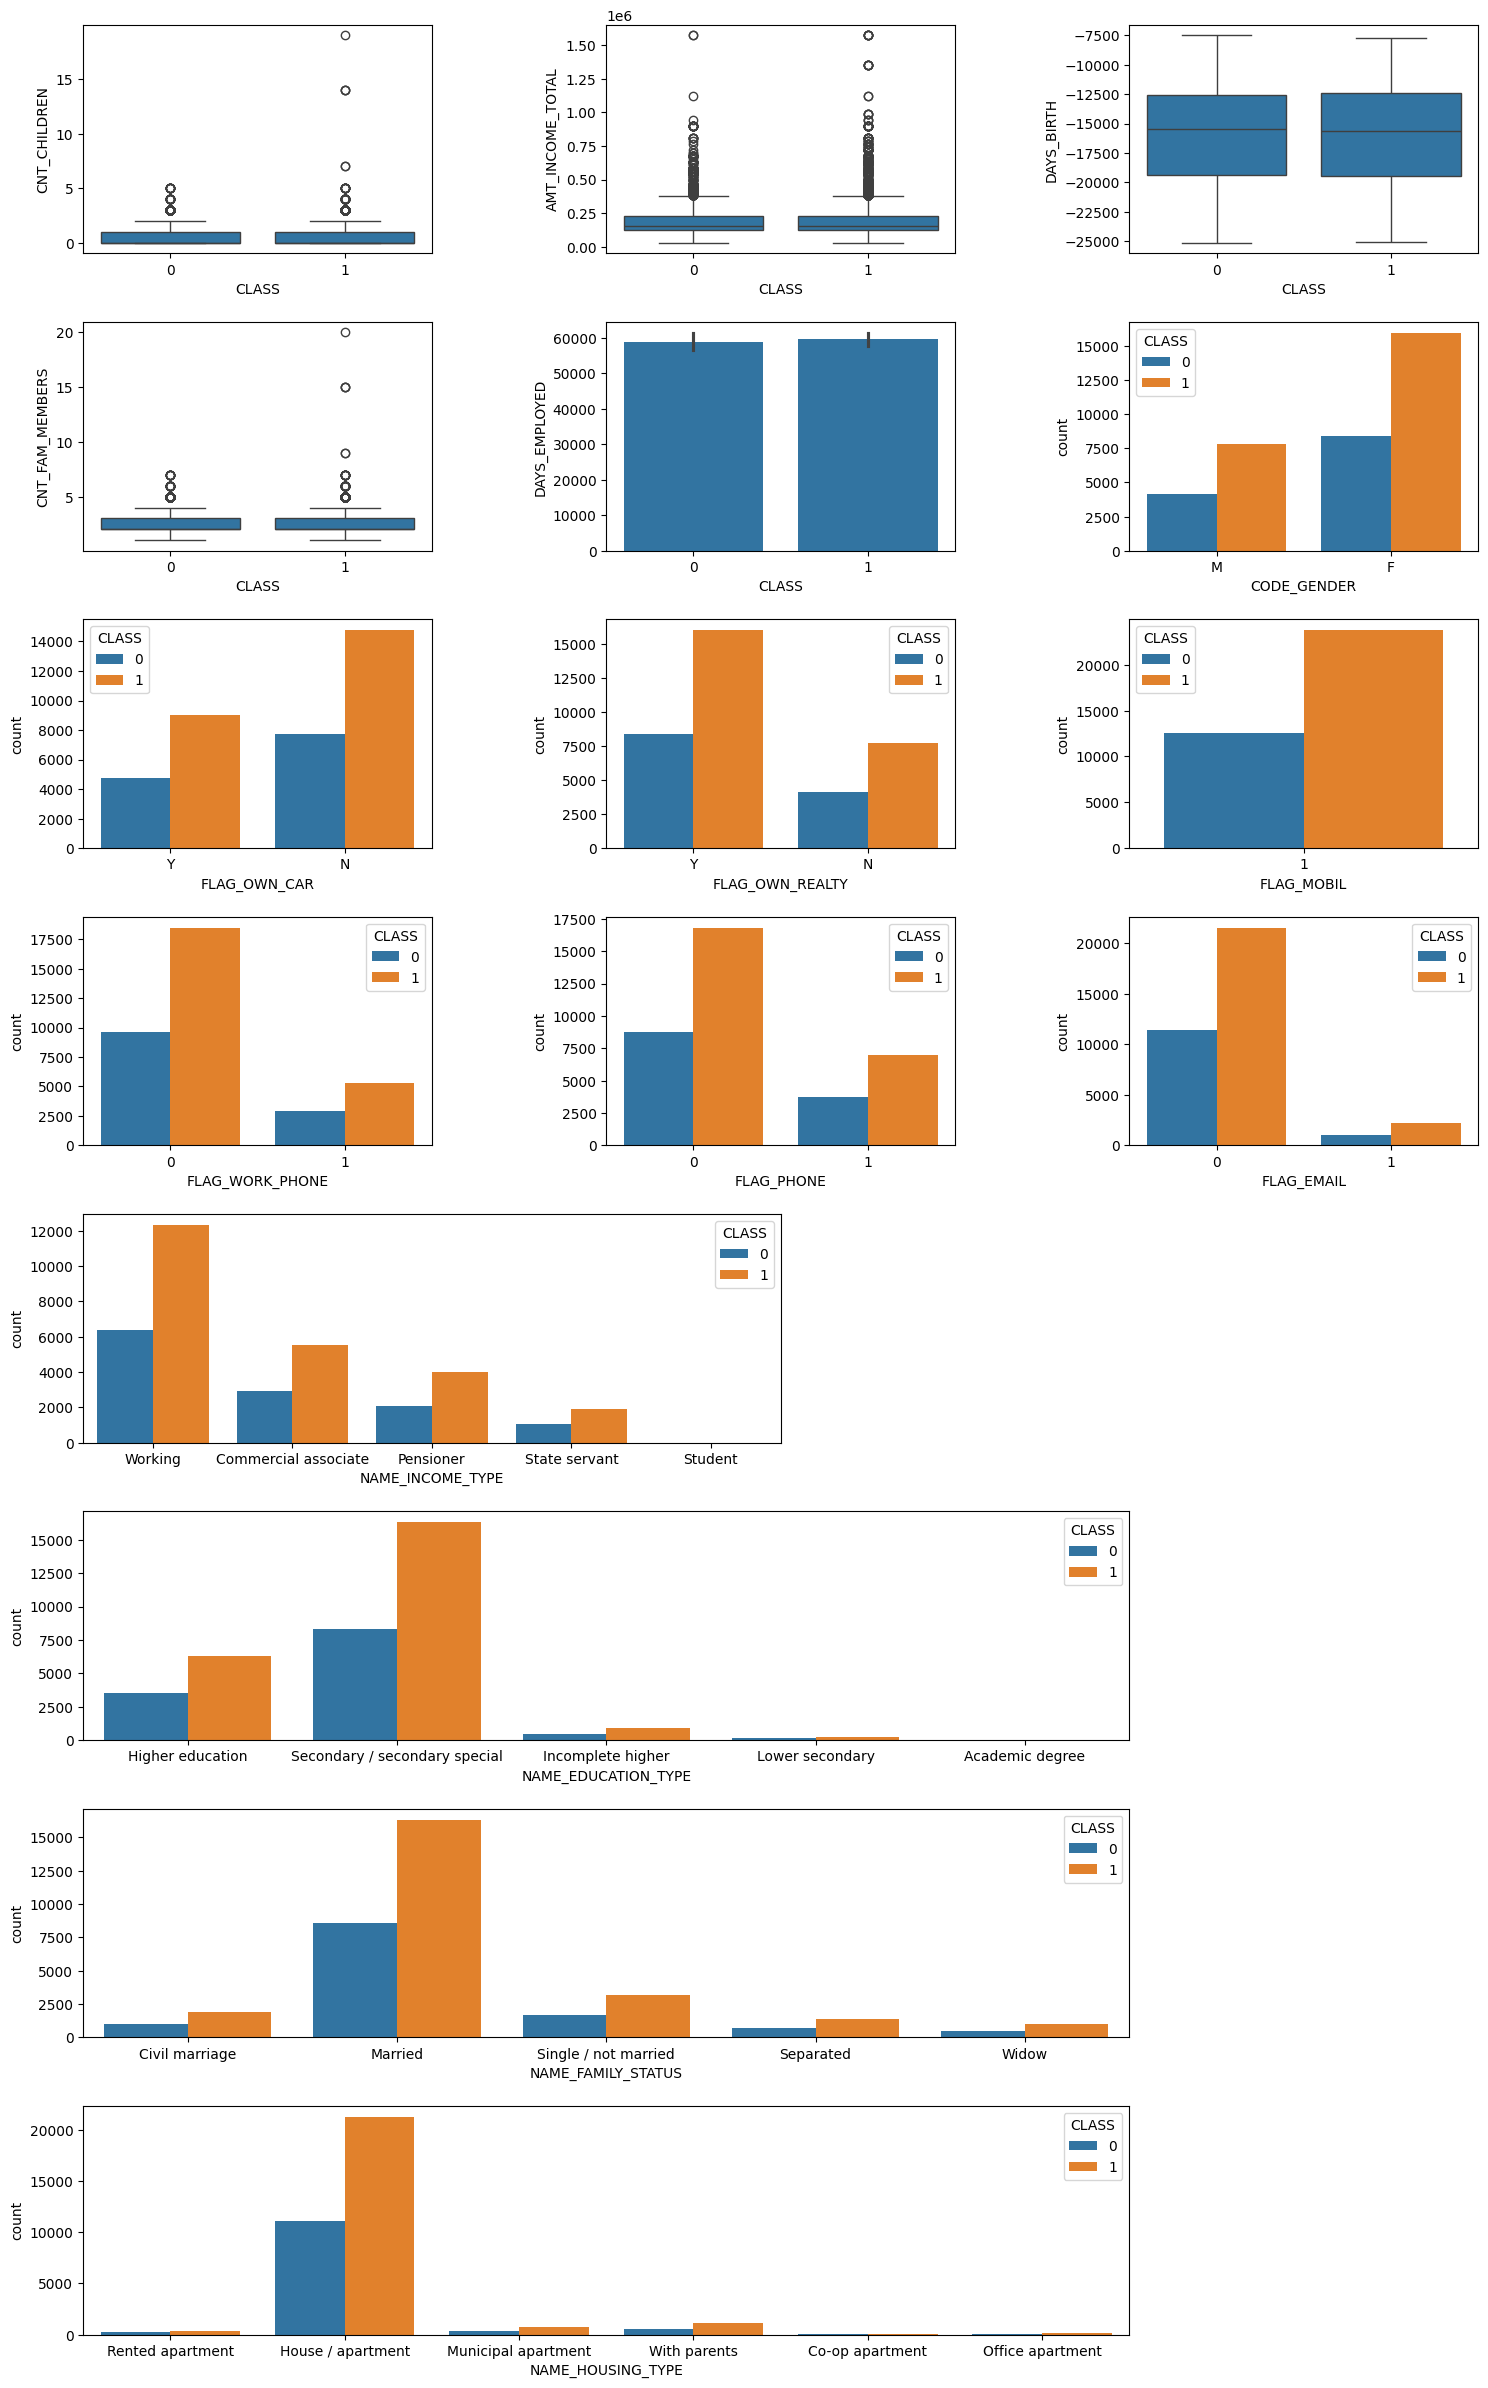

In [ ]:
def plot_analysis():
  fig = plt.figure(figsize = (18,30))
  fig.subplots_adjust(wspace = 0.5, hspace = 0.3)
  var=['CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'DAYS_BIRTH', 'CNT_FAM_MEMBERS']
  for i in range(len(var)):
    plot = fig.add_subplot(8,3,i+1)
    sns.boxplot(data = appl, x = 'CLASS', y = var[i])

  plot = fig.add_subplot(8,3,5)
  sns.barplot(data = appl, x = 'CLASS', y = 'DAYS_EMPLOYED')


  var = ['CODE_GENDER','FLAG_OWN_CAR','FLAG_OWN_REALTY',
         'FLAG_MOBIL', 'FLAG_WORK_PHONE', 'FLAG_PHONE','FLAG_EMAIL']

  for i in range(len(var)):

    plot = fig.add_subplot(8,3,i+6)
    sns.countplot(data = appl, x = var[i], hue = 'CLASS')

  # plot = fig.add_subplot(6,3,7)
  # sns.countplot(data = appl, x = 'FLAG_OWN_REALTY', hue = 'CLASS')

  plot = fig.add_subplot(8,3,13)
  sns.countplot(data = appl, x = 'NAME_INCOME_TYPE', hue = 'CLASS')

  left, bottom, width, height = plot.get_position().bounds
  plot.set_position([left, bottom, width * 2, height])

  plot = fig.add_subplot(8,3,16)
  sns.countplot(data = appl, x = 'NAME_EDUCATION_TYPE', hue = 'CLASS')

  left, bottom, width, height = plot.get_position().bounds
  plot.set_position([left, bottom, width * 3, height])

  plot = fig.add_subplot(8,3,19)
  sns.countplot(data = appl, x = 'NAME_FAMILY_STATUS', hue = 'CLASS')

  left, bottom, width, height = plot.get_position().bounds
  plot.set_position([left, bottom, width * 3, height])

  plot = fig.add_subplot(8,3,22)
  sns.countplot(data = appl, x = 'NAME_HOUSING_TYPE', hue = 'CLASS')
  left, bottom, width, height = plot.get_position().bounds
  plot.set_position([left, bottom, width * 3, height])

plot_analysis()


Per ogni variabile qualitativa è stata realizzata una tabella di contingenza rispetto alla variabile target, così da evidenziare eventuali differenze nelle distribuzioni delle diverse modalità di ogni variabile.

In generale si nota per quasi tutte le variabili, le modalità mostrano la stessa distribuzione della variabile target osservata sull'intero dataset.

Fanno eccezione la modalità *Accademic degree* della variabile NAME_EDUCATION_TYPE, la modalità *Student* di NAME_INCOME_TYPE e la modalità *Co-op apartment* di NAME_HOUSING_TYPE; in tutti e tre i casi la frequenza della classe 0 è risultata maggiore rispetto alla frequenza sull'intero dataset.

In [ ]:
for var in var_qual:
  print(pd.crosstab(appl[var], appl.CLASS, normalize='index'))
  print('\n'+' - '*10+'\n')

CLASS               0         1
CODE_GENDER                    
F            0.344833  0.655167
M            0.344874  0.655126

 -  -  -  -  -  -  -  -  -  - 

CLASS                0         1
FLAG_OWN_CAR                    
N             0.343781  0.656219
Y             0.346586  0.653414

 -  -  -  -  -  -  -  -  -  - 

CLASS                   0         1
FLAG_OWN_REALTY                    
N                0.349095  0.650905
Y                0.342776  0.657224

 -  -  -  -  -  -  -  -  -  - 

CLASS                        0         1
NAME_INCOME_TYPE                        
Commercial associate  0.347708  0.652292
Pensioner             0.342166  0.657834
State servant         0.359785  0.640215
Student               0.636364  0.363636
Working               0.341890  0.658110

 -  -  -  -  -  -  -  -  -  - 

CLASS                                 0         1
NAME_EDUCATION_TYPE                              
Academic degree                0.437500  0.562500
Higher education           

Per ciascuna varaibile quantitativa è stato realizzato un boxplot e calcolati media, mediana (50° percentile) deviazione standard, massimo, minimo 25° e 75° percentile, riportati di seguito.


In [ ]:
appl[var_quant].describe()

,CNT_CHILDREN,AMT_INCOME_TOTAL,DAYS_BIRTH,DAYS_EMPLOYED,CNT_FAM_MEMBERS
count,36277.000000,3.627700e+04,36277.000000,36277.000000,36277.000000
mean,0.430548,1.866177e+05,-15971.624142,59254.484742,2.198749
std,0.742706,1.017174e+05,4201.710424,137645.528556,0.911950
min,0.000000,2.700000e+04,-25152.000000,-15713.000000,1.000000
25%,0.000000,1.215000e+05,-19439.000000,-3153.000000,2.000000
50%,0.000000,1.575000e+05,-15558.000000,-1555.000000,2.000000
75%,1.000000,2.250000e+05,-12461.000000,-407.000000,3.000000
max,19.000000,1.575000e+06,-7489.000000,365243.000000,20.000000


Si nota che la variabile DAYS_EMPLOYED assume come valore massimo 365243 giorni che corrispondono ad un periodo di disoccupazione (se positiva tale variabile indica il numero di giorni senza occupazione) di oltre 1000 anni, un valore assolutamente non plausibile.

In [ ]:
appl[appl.DAYS_EMPLOYED > appl.DAYS_BIRTH.min()*(-1)].DAYS_EMPLOYED.shape[0]

6135

In [ ]:
appl[appl.DAYS_EMPLOYED > appl.DAYS_BIRTH.min()*(-1)].DAYS_EMPLOYED.mean()

365243.0

In [ ]:
appl[(appl.DAYS_EMPLOYED > 0) & (appl.NAME_INCOME_TYPE != 'Pensioner')].shape[0]

0

In [ ]:
appl[(appl.DAYS_EMPLOYED == appl.DAYS_EMPLOYED.max()) & (appl.NAME_INCOME_TYPE == 'Pensioner')].shape[0]

6135

In [ ]:
appl[(appl.DAYS_EMPLOYED != appl.DAYS_EMPLOYED.max()) & (appl.NAME_INCOME_TYPE == 'Pensioner')].shape[0]

17

In 6135 osservazioni i giorni da cui il soggetto risulta disoccuppato sono maggiori del numero di giorni da cui è nato, dato ovviamente incosistente. In tutte queste osservazioni il valore medio dalla variabile DAYS_EMPLOYED è pari esattamente al valore massimo della variabile il che implica che in tutte queste osservazioni il valore della variabile DAYS_EMPLOYED sia proprio 365243. Si nota, infine, che tutte le osservazioni con tale valore anomalo appartengono alla categoria *Pensioner* e che gli appartenenti a tale categoria sono gli unici soggetti ad avere un valore positivo per quanto concenrne la variabile DAYS_EMPLOYED.

Si è quindi deciso di sostituire il valore anomalo con il valore medio assunto dalla variabile DAYS_EMPLOYED nella catagoria *Pensioner*.

In [ ]:
appl[(appl.DAYS_EMPLOYED != appl.DAYS_EMPLOYED.max()) & (appl.NAME_INCOME_TYPE == 'Pensioner')].DAYS_EMPLOYED.describe()

count      17.000000
mean    -2310.647059
std      2404.851319
min     -7553.000000
25%     -2745.000000
50%     -1325.000000
75%      -672.000000
max      -198.000000
Name: DAYS_EMPLOYED, dtype: float64

In [ ]:
val = int(appl[(appl.DAYS_EMPLOYED != appl.DAYS_EMPLOYED.max()) & (appl.NAME_INCOME_TYPE == 'Pensioner')].DAYS_EMPLOYED.mean())
ind = appl[(appl.DAYS_EMPLOYED == appl.DAYS_EMPLOYED.max()) & (appl.NAME_INCOME_TYPE == 'Pensioner')].index

appl.loc[ind, 'DAYS_EMPLOYED'] = val

In [ ]:
appl.DAYS_EMPLOYED.describe()

count    36457.000000
mean     -2589.044985
std       2153.579216
min     -15713.000000
25%      -3153.000000
50%      -2310.000000
75%      -1169.000000
max        -17.000000
Name: DAYS_EMPLOYED, dtype: float64

In [ ]:
appl = pd.read_csv(PATH+'Dataset_final.csv')

In [ ]:
#appl = appl[appl.DAYS_EMPLOYED != appl.DAYS_EMPLOYED.max()]

Di seguito sono riportati i risulatati dell'analisi svolta sulle variabili del dateset eseguita nuovamente dopo l'operazione descritta in precedenza. In generale, non si notano differenze se non, come ci si aspetta, nelle statitistiche della variabile DAYS_EMPLOYED.

In [ ]:
for var in var_qual:
  print(pd.crosstab(appl[var], appl.CLASS, normalize='index'))
  print('\n'+' - '*10+'\n')

CLASS               0         1
CODE_GENDER                    
F            0.344833  0.655167
M            0.344874  0.655126

 -  -  -  -  -  -  -  -  -  - 

CLASS                0         1
FLAG_OWN_CAR                    
N             0.343781  0.656219
Y             0.346586  0.653414

 -  -  -  -  -  -  -  -  -  - 

CLASS                   0         1
FLAG_OWN_REALTY                    
N                0.349095  0.650905
Y                0.342776  0.657224

 -  -  -  -  -  -  -  -  -  - 

CLASS                        0         1
NAME_INCOME_TYPE                        
Commercial associate  0.347708  0.652292
Pensioner             0.342166  0.657834
State servant         0.359785  0.640215
Student               0.636364  0.363636
Working               0.341890  0.658110

 -  -  -  -  -  -  -  -  -  - 

CLASS                                 0         1
NAME_EDUCATION_TYPE                              
Academic degree                0.437500  0.562500
Higher education           

In [ ]:
appl[appl.NAME_INCOME_TYPE=='Pensioner'].shape[0]

6152

In [ ]:
appl[var_quant].describe()

,CNT_CHILDREN,AMT_INCOME_TOTAL,DAYS_BIRTH,DAYS_EMPLOYED,CNT_FAM_MEMBERS
count,36277.000000,3.627700e+04,36277.000000,36277.000000,36277.000000
mean,0.430548,1.866177e+05,-15971.624142,-2610.666621,2.198749
std,0.742706,1.017174e+05,4201.710424,2151.389585,0.911950
min,0.000000,2.700000e+04,-25152.000000,-15713.000000,1.000000
25%,0.000000,1.215000e+05,-19439.000000,-3153.000000,2.000000
50%,0.000000,1.575000e+05,-15558.000000,-2431.000000,2.000000
75%,1.000000,2.250000e+05,-12461.000000,-1170.000000,3.000000
max,19.000000,1.575000e+06,-7489.000000,-17.000000,20.000000


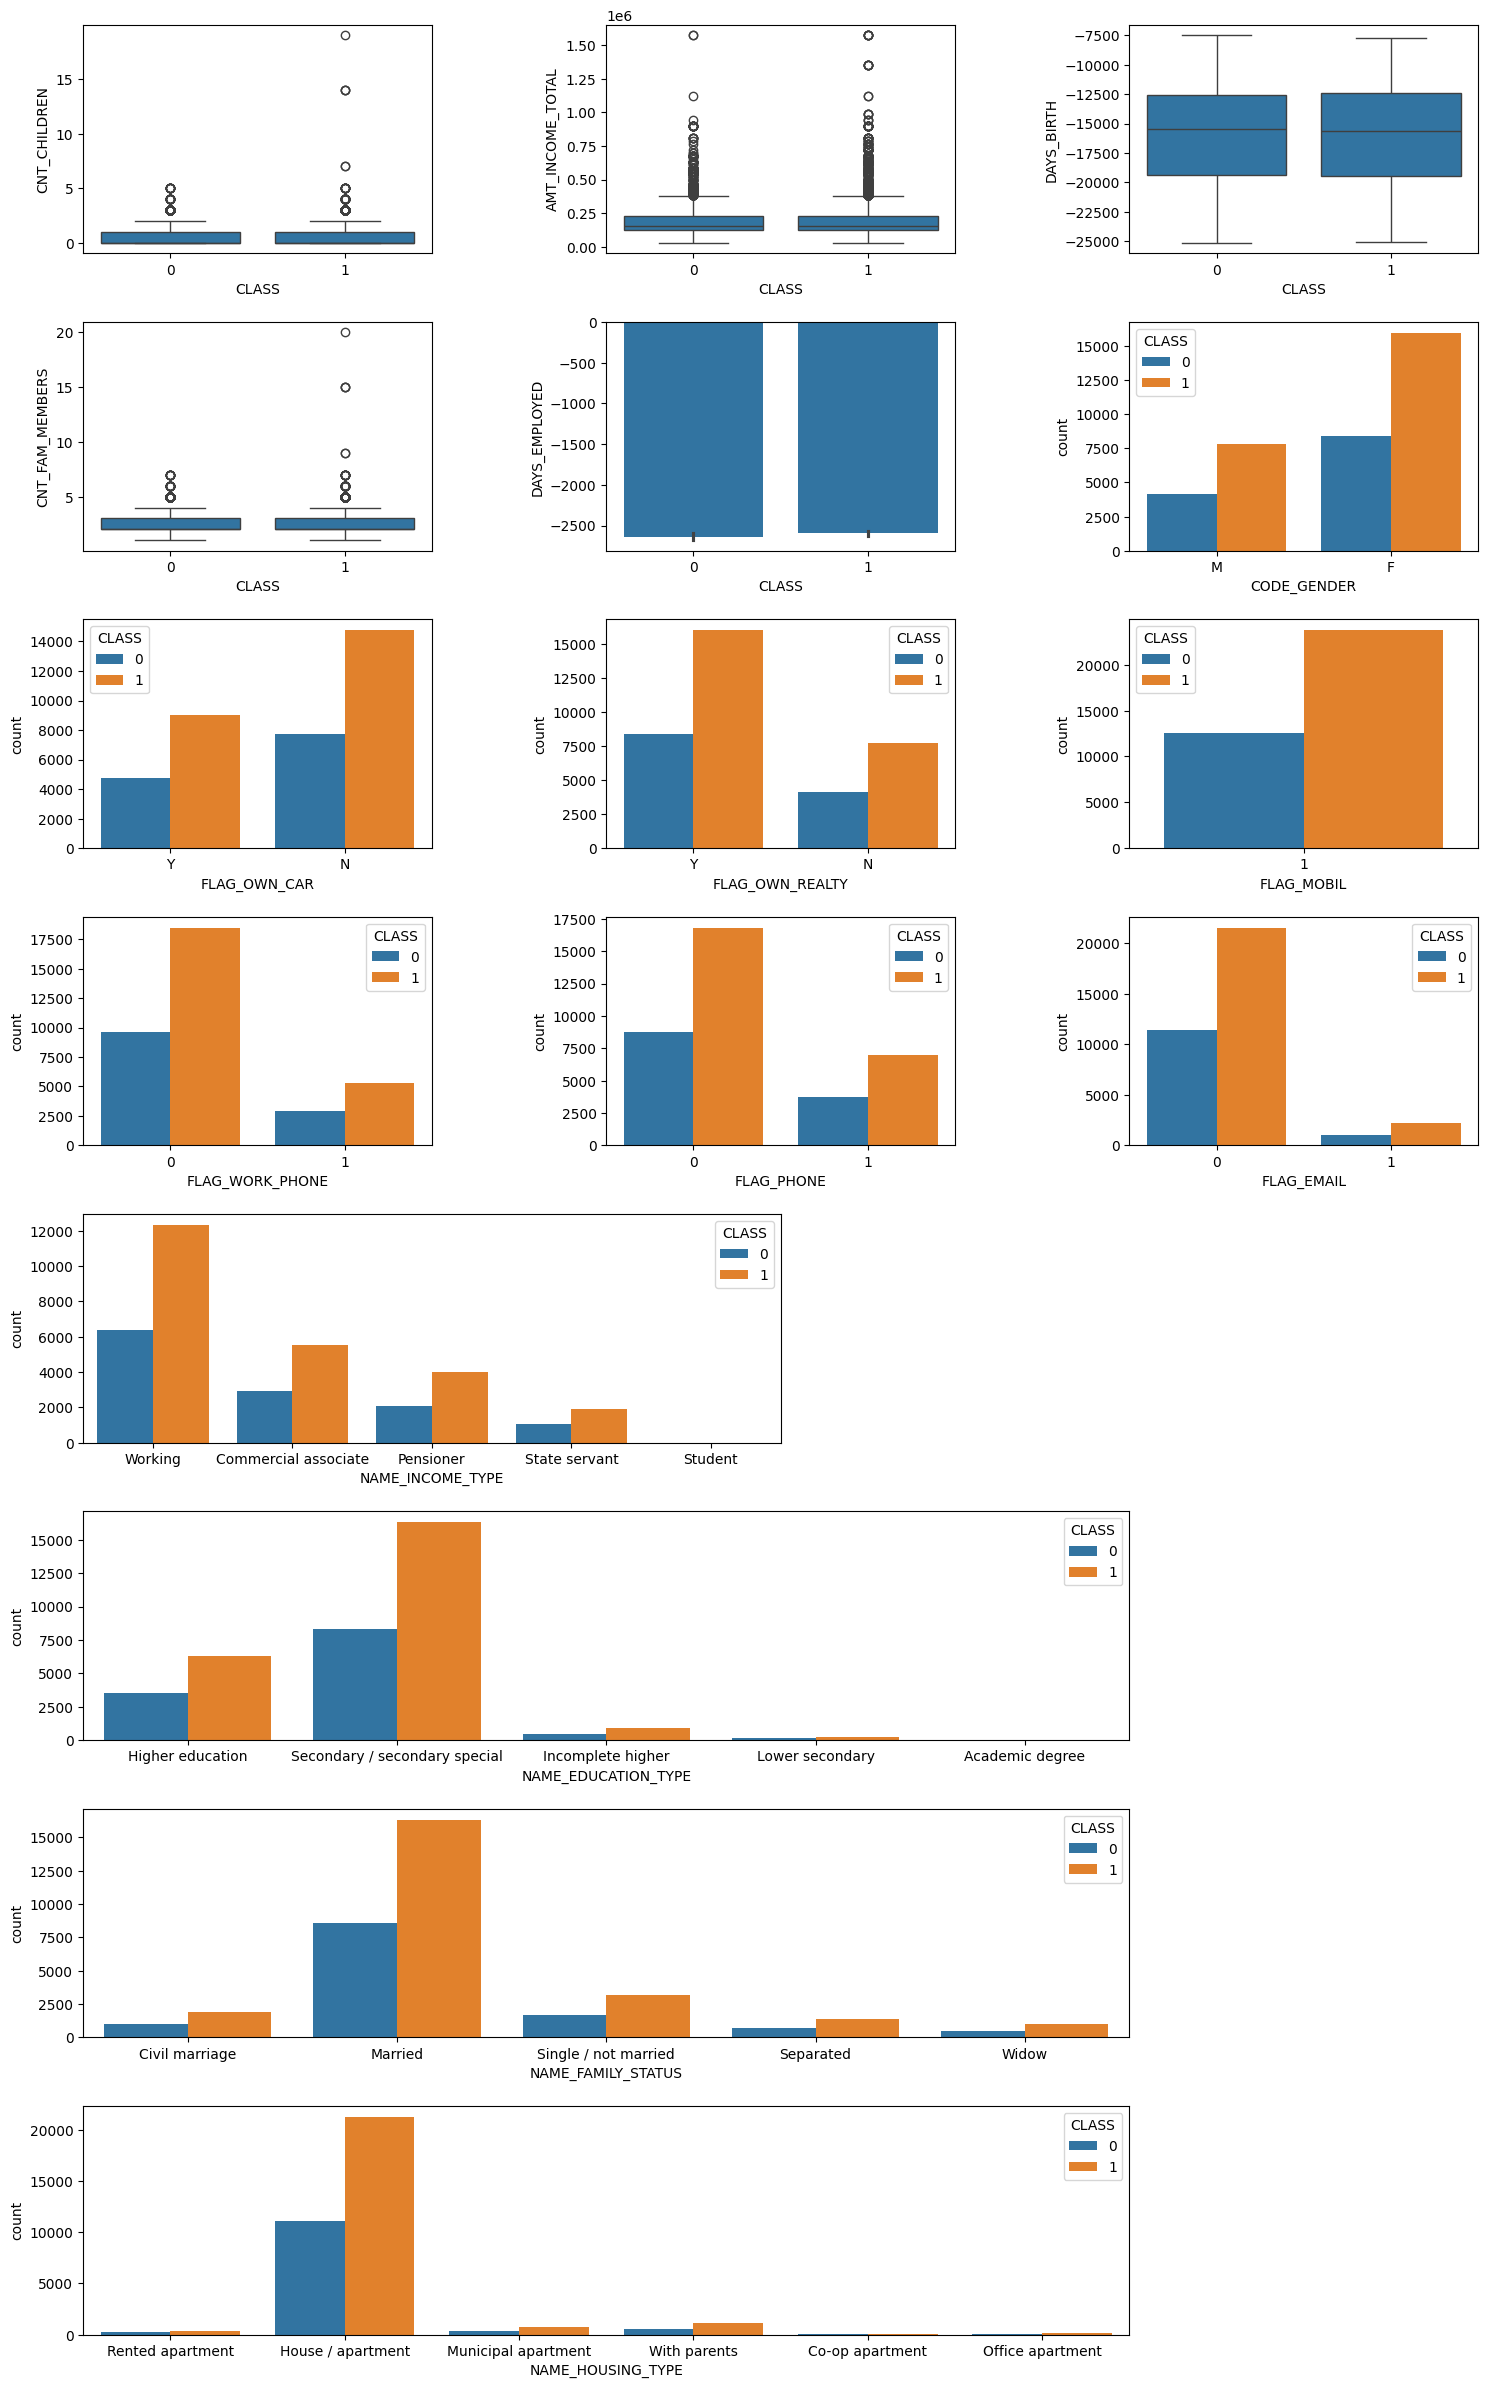

In [ ]:
plot_analysis()

Come evidenziato in precedenza, circa il 31% delle osservazioni non presenta un valore per la variabile OCCUPATION_TYPE, si è quindi deciso di rimuovere tale feature.

Inoltre, si nota che la variabile FLAG_MOBIL assume il valore 1 in tutte le osservazioni, essendo quindi del tutto ininfluente anch'essa è stata rimossa.

In [ ]:
appl = appl.drop('OCCUPATION_TYPE', axis = 1)

In [ ]:
appl = appl.drop('FLAG_MOBIL', axis = 1)

In [ ]:
appl.shape

(36457, 17)

In [ ]:
appl.to_csv(PATH+'Dataset_final_v2.csv', index = False)

### Modelli
Al  fine di classifcare gli utenti nelle classi 0 o 1 e quindi fornire un supporto per la decisione sul concedere o meno la carta di credito sono stati realizzati diversi modelli che sfruttano metodi differenti, le cui performance sono state confrontate nella sezione successiva.

In particolare, sono stati testati 4 tipi di modelli:
* Regressione Logistica
* Support Vector Machine (SVM)
* Naive-Bayes (basati sul Teorema di Bayes)
* K-nearest neighbors (KNN)

#### Regressione Logistica

In [ ]:
appl = pd.read_csv(PATH+'Dataset_final_v2.csv')
X = appl.drop(['ID','CLASS'],axis = 1)
y = appl['CLASS']

X_train_lr, X_test_lr, y_train_lr, y_test_lr = train_test_split(X,y,test_size = .2, random_state = 0)


Si è deciso di utilizzare la classe *Pipeline* della libreria *imblearn* in quanto, oltre a consentire di utilizzare classi specifiche per il sampling, assicura che eventuali campionamenti vengano effettuati esclusiavemente sul Training Set, anche nella funzione *cross_validate* di *sklearn* utilizzata per effettuare la cross-validation. Infatti, per valuatare l'eventuale presenza di overfitting e per testare le diverse configurazioni di parametetri è stata eseguita la cross-validation sul Training Set per tutti i tipi di modelli selezionati.

In [ ]:
#PREPROCESSOR

y_n_features = ['FLAG_OWN_CAR','FLAG_OWN_REALTY']


categorical_features = ['CODE_GENDER',
                        'NAME_INCOME_TYPE',
                        'NAME_EDUCATION_TYPE',
                        'NAME_FAMILY_STATUS',
                        'NAME_HOUSING_TYPE']



preprocessor_lr = ColumnTransformer(
    transformers = [
        ('y_n', OrdinalEncoder(), y_n_features),
        ('cat', OneHotEncoder(), categorical_features)
        ]
)


pipe_lr = Pipeline(steps = [('preprocessor', preprocessor_lr),
                            ('sd',StandardScaler(with_mean=False)),
                            ('lr', LogisticRegression())])

In [ ]:
  score_cv = cross_validate( X = X_train_lr,
                             y = y_train_lr,
                             estimator = pipe_lr,
                             cv=5,
                             scoring = SCORING_CV,
                             return_train_score = True)

In [ ]:
print_cv_score(score_cv)

TRAIN SET:
Accuracy:  0.653
Precision CLASS 1:  0.653
Precision CLASS 0:  0.621
Recall CLASS 1:  1.000
Recall CLASS 0:  0.001

TEST SET:
Accuracy:  0.653
Precision CLASS 1:  0.653
Precision CLASS 0:  0.633
Recall CLASS 1:  1.000
Recall CLASS 0:  0.001


In [ ]:
pipe_lr_over = Pipeline(steps = [('preprocessor', preprocessor_lr),
                                 ('sd',StandardScaler(with_mean=False)),
                                 ('oversampling',SMOTE(sampling_strategy=1)),
                                 ('lr', LogisticRegression())])

In [ ]:
  score_cv = cross_validate( X = X_train_lr,
                             y = y_train_lr,
                             estimator = pipe_lr_over,
                             cv=5,
                             scoring = SCORING_CV,
                             return_train_score = True)

In [ ]:
print_cv_score(score_cv)

TRAIN SET:
Accuracy:  0.533
Precision CLASS 1:  0.663
Precision CLASS 0:  0.360
Recall CLASS 1:  0.580
Recall CLASS 0:  0.446

TEST SET:
Accuracy:  0.524
Precision CLASS 1:  0.655
Precision CLASS 0:  0.350
Recall CLASS 1:  0.572
Recall CLASS 0:  0.433


#### SVM



In [ ]:
appl = pd.read_csv(PATH+'Dataset_final_v2.csv')

In [ ]:
appl.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,CLASS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,2.0,0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,2.0,0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,2.0,1
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,1.0,0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,1.0,0


In [ ]:
appl.shape

(36457, 18)

In [ ]:
X = appl.drop(['ID','CLASS'], axis = 1)
y = appl['CLASS']
X_train_svm, X_test_svm, y_train_svm, y_test_svm = train_test_split(X, y, test_size =.2, random_state = 0)


##### Pipeline
La pipeline prevede una prima parte di preprocessing che consiste in:
* Standardizzazione delle variabili quantitative
* One Hot Encoding (OHE) delle variabili qualitative categoriche
* Codifica 0\1 delle variabili YES\NO


In [ ]:
#PREPROCESSOR

y_n_features = ['FLAG_OWN_CAR','FLAG_OWN_REALTY']

numerical_features = ['CNT_CHILDREN',
                      'AMT_INCOME_TOTAL',
                      'DAYS_BIRTH',
                      'DAYS_EMPLOYED',
                      'CNT_FAM_MEMBERS']

categorical_features = ['CODE_GENDER',
                        'NAME_INCOME_TYPE',
                        'NAME_EDUCATION_TYPE',
                        'NAME_FAMILY_STATUS',
                        'NAME_HOUSING_TYPE']



preprocessor = ColumnTransformer(
    transformers = [
        ('y_n', OrdinalEncoder(), y_n_features),
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(), categorical_features)
        ]
)


In [ ]:
pipe_svc = Pipeline(
    steps = [('preprocessor', preprocessor),
             ('svc', SVC())]
)

Nei modelli SVM uno dei parametri più importanti è il tipo di kernel utilizzato. Per stabilire il kernel in grado di fornire le prestazioni migliori e valutare l'eventuale presenza di overfitting, sono stati testati tutti i tipi di kernel disponibili per la classe *SVC* di *sklearn* mediante cross-validation sul Training Set.

In [ ]:
kernels = ['linear', 'poly', 'sigmoid', 'rbf']

scores=[]

for kernel in kernels:

  pipe_svc.set_params(svc__kernel = kernel)
  score = cross_validate( X = X_train_svm,
                          y = y_train_svm,
                          estimator = pipe_svc,
                          cv=5,
                          scoring = SCORING_CV,
                          return_train_score = True)

  scores.append(score)


In [ ]:
df_comp = get_df_comp_CV(scores, kernels)

Text(0.5, 1.0, 'Recall - Class 0')

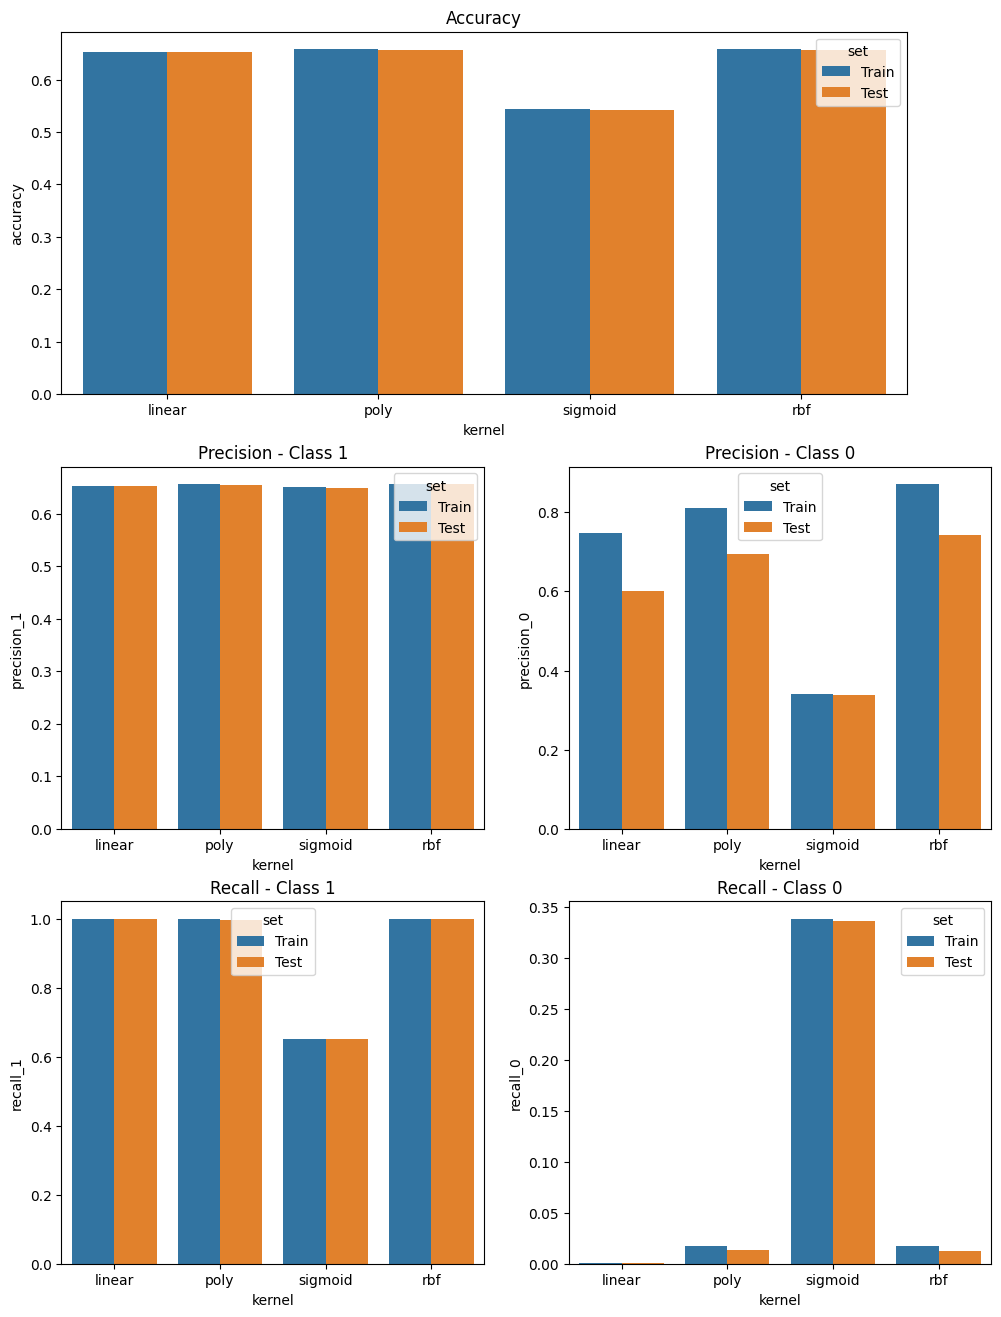

In [ ]:
fig = plt.figure(figsize = (12,16) )
fig.subplots_adjust(hspace = 0.2)

plot = fig.add_subplot(3,2,1)
sns.barplot(data = df_comp, x = 'kernel', y = 'accuracy', hue = 'set')
left, bottom, width, height = plot.get_position().bounds
plot.set_position([left, bottom, width * 2, height])
plot.set_title('Accuracy')

plot = fig.add_subplot(3,2,3)
sns.barplot(data = df_comp, x = 'kernel', y = 'precision_1', hue = 'set')
plot.set_title('Precision - Class 1')

plot = fig.add_subplot(3,2,4)
sns.barplot(data = df_comp, x = 'kernel', y = 'precision_0', hue = 'set')
plot.set_title('Precision - Class 0')

plot = fig.add_subplot(3,2,5)
sns.barplot(data = df_comp, x = 'kernel', y = 'recall_1', hue = 'set')
plot.set_title('Recall - Class 1')

plot = fig.add_subplot(3,2,6)
sns.barplot(data = df_comp, x = 'kernel', y = 'recall_0', hue = 'set')
plot.set_title('Recall - Class 0')

In [ ]:
for i in range(len(scores)):
  print('KERNEL: '+kernels[i]+'\n')
  score_train = scores[i]['train_accuracy'].mean()
  print(f'Accuracy TRAIN: {score_train:.3f}')
  score_test = scores[i]['test_accuracy'].mean()
  print(f'Accuracy TEST: {score_test:.3f}')
  print('\n'+' * '*10+'\n')


KERNEL: linear

Accuracy TRAIN: 0.653
Accuracy TEST: 0.653

 *  *  *  *  *  *  *  *  *  * 

KERNEL: poly

Accuracy TRAIN: 0.658
Accuracy TEST: 0.656

 *  *  *  *  *  *  *  *  *  * 

KERNEL: sigmoid

Accuracy TRAIN: 0.543
Accuracy TEST: 0.542

 *  *  *  *  *  *  *  *  *  * 

KERNEL: rbf

Accuracy TRAIN: 0.658
Accuracy TEST: 0.656

 *  *  *  *  *  *  *  *  *  * 



Si nota come i valori di recall della classe 0 siano molto bassi per tutti i tipi di kernel, questo può essere dovuto allo sbilanciamento del dataset. Per superare tale problema si è provato ad eseguire un oversampling sulla classe minoritaria utilizzando il metodo SMOTE, portando in parità la numerosità delle due classi del target.

##### Pipeline con oversampling (SMOTE)

In [ ]:
pipe_svc_over = Pipeline(
    steps = [('preprocessor', preprocessor),
             ('sampler', SMOTE(sampling_strategy= 1, random_state = 0)),
             ('svc', SVC())]
)

In [ ]:
kernels = ['linear', 'poly', 'sigmoid', 'rbf']

scores = []

SCORING_CV = {'accuracy': 'accuracy',
           'precision_1': 'precision',
           'precision_0':make_scorer(precision_0),
           'recall_1':'recall',
           'recall_0':make_scorer(recall_0)}

for kernel in kernels:

  pipe_svc_over.set_params(svc__kernel = kernel)
  score = cross_validate( X = X_train_svm,
                          y = y_train_svm,
                          estimator = pipe_svc_over,
                          cv=5,
                          scoring = SCORING_CV,
                          return_train_score = True)

  scores.append(score)

Text(0.5, 1.0, 'Recall - Class 0')

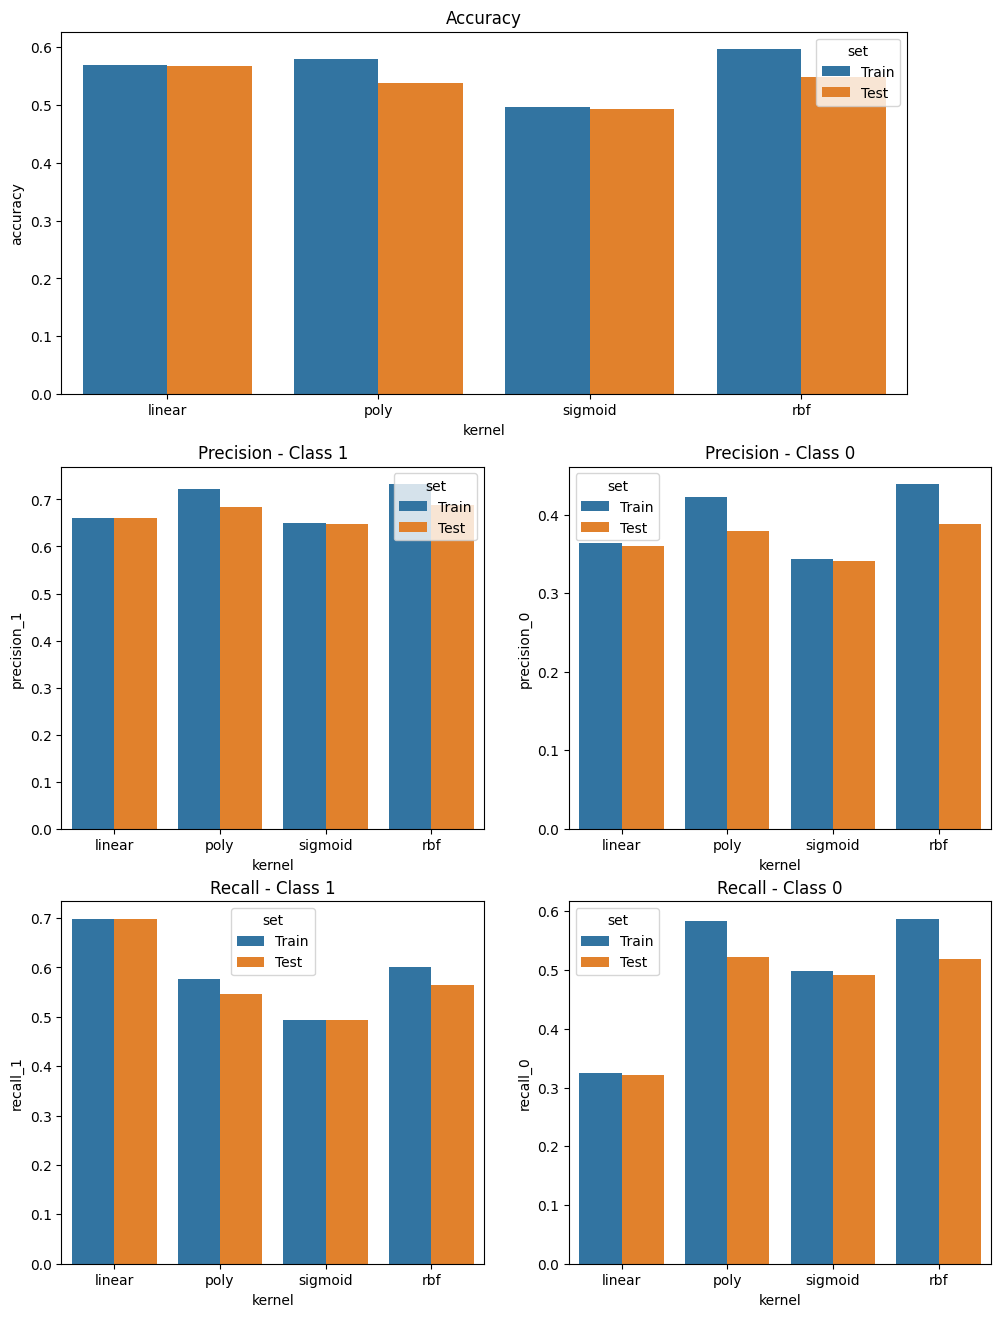

In [ ]:
df_comp = get_df_comp_CV(scores, kernels)

fig = plt.figure(figsize = (12,16) )
fig.subplots_adjust(hspace = 0.2)

plot = fig.add_subplot(3,2,1)
sns.barplot(data = df_comp, x = 'kernel', y = 'accuracy', hue = 'set')
left, bottom, width, height = plot.get_position().bounds
plot.set_position([left, bottom, width * 2, height])
plot.set_title('Accuracy')

plot = fig.add_subplot(3,2,3)
sns.barplot(data = df_comp, x = 'kernel', y = 'precision_1', hue = 'set')
plot.set_title('Precision - Class 1')

plot = fig.add_subplot(3,2,4)
sns.barplot(data = df_comp, x = 'kernel', y = 'precision_0', hue = 'set')
plot.set_title('Precision - Class 0')

plot = fig.add_subplot(3,2,5)
sns.barplot(data = df_comp, x = 'kernel', y = 'recall_1', hue = 'set')
plot.set_title('Recall - Class 1')

plot = fig.add_subplot(3,2,6)
sns.barplot(data = df_comp, x = 'kernel', y = 'recall_0', hue = 'set')
plot.set_title('Recall - Class 0')

In [ ]:
for i in range(len(scores)):
  print('KERNEL: '+kernels[i]+'\n')
  score_train = scores[i]['train_accuracy'].mean()
  print(f'Accuracy TRAIN: {score_train:.3f}')
  score_test = scores[i]['test_accuracy'].mean()
  print(f'Accuracy TEST: {score_test:.3f}')
  print('\n'+' * '*10+'\n')

KERNEL: linear

Accuracy TRAIN: 0.569
Accuracy TEST: 0.567

 *  *  *  *  *  *  *  *  *  * 

KERNEL: poly

Accuracy TRAIN: 0.579
Accuracy TEST: 0.538

 *  *  *  *  *  *  *  *  *  * 

KERNEL: sigmoid

Accuracy TRAIN: 0.496
Accuracy TEST: 0.493

 *  *  *  *  *  *  *  *  *  * 

KERNEL: rbf

Accuracy TRAIN: 0.597
Accuracy TEST: 0.549

 *  *  *  *  *  *  *  *  *  * 



#### Naive-Bayes
I modelli Naive-Bayes si basano sul Teorema di Naive-Bayes; al fine di utilizzare tali modelli tutte le varibili quantitave sono state trasformate in variabili qualitative dividendole in classi, successivamente, tutte le feature del dataset sono state codificate mediante il metodo OHE così che per ciascuna di esse gli unici valori possibili fossero 0 e 1.

Sono stati testati due tipi di modelli Naive-Bayes: il Bernoulli Naive-Bayes e il Complement Naive-Bayes, quest'ultimo è stato scelto in quanto tende a funzionare meglio con dataset sbilanciati.

In [ ]:
appl = pd.read_csv(PATH+'Dataset_final_v2.csv')

In [ ]:
appl.shape

(36457, 17)

In [ ]:
appl.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,CLASS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,0,0,2.0,0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,0,0,2.0,0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,0,0,0,2.0,1
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,0,1,1,1.0,0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,0,1,1,1.0,0


In [ ]:
var_qual = ['CODE_GENDER','NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE','NAME_FAMILY_STATUS','NAME_HOUSING_TYPE']

In [ ]:
len(var_qual)

10

In [ ]:
len(var_quant)

5

In [ ]:
mapping = {'Y': 1, 'N':0}

appl['FLAG_OWN_CAR'] = appl['FLAG_OWN_CAR'].map(lambda x: mapping[x])
appl['FLAG_OWN_REALTY'] = appl['FLAG_OWN_REALTY'].map(lambda x: mapping[x])

In [ ]:
appl = pd.get_dummies(appl, columns = var_qual)

La variabile CNT_CHILDREN è stata divisa nella seguenti classi:
* 0 (nessun figlio)
* 1 figlio
* 2 figli
* 3-4 figli
* Più di 4 figli


In [ ]:
appl['CNT_CHILDREN'] = pd.cut(appl.CNT_CHILDREN, bins=[0,0.1,1,2,4,appl.CNT_CHILDREN.max()], include_lowest=True, labels = ['0', '1','2','3-4','> 4'])

In [ ]:
appl.CNT_CHILDREN.value_counts()

0      25201
1       7492
2       3256
3-4      482
> 4       26
Name: CNT_CHILDREN, dtype: int64

Gli estremi delle classi della variabili AMT_INCOME_TOTAL, DAYS_BIRTH e DAYS_EMPLOYED sono stati determinati considerndo i quartili.

In [ ]:
appl.AMT_INCOME_TOTAL = pd.cut(appl.AMT_INCOME_TOTAL, bins = appl.AMT_INCOME_TOTAL.quantile([0,0.25,0.5,0.75,1]), include_lowest= True)

In [ ]:
appl.AMT_INCOME_TOTAL.value_counts()

(157500.0, 225000.0]     10125
(26999.999, 121500.0]     9393
(121500.0, 157500.0]      9170
(225000.0, 1575000.0]     7769
Name: AMT_INCOME_TOTAL, dtype: int64

In [ ]:
appl.DAYS_BIRTH = pd.cut(appl.DAYS_BIRTH, bins = appl.DAYS_BIRTH.quantile([0,0.25,0.5,0.75,1]), include_lowest= True)

appl.DAYS_EMPLOYED = pd.cut(appl.DAYS_EMPLOYED, bins = appl.DAYS_EMPLOYED.quantile([0,0.25,0.5,0.75,1]), include_lowest= True)

In [ ]:
appl.DAYS_BIRTH.value_counts()

(-19438.0, -15563.0]      9120
(-25152.001, -19438.0]    9115
(-12462.0, -7489.0]       9114
(-15563.0, -12462.0]      9108
Name: DAYS_BIRTH, dtype: int64

In [ ]:
appl.DAYS_EMPLOYED.value_counts()

(-15713.001, -3153.0]    9126
(-1552.0, -408.0]        9113
(-408.0, 365243.0]       9112
(-3153.0, -1552.0]       9106
Name: DAYS_EMPLOYED, dtype: int64

In [ ]:
appl.CNT_FAM_MEMBERS.describe()

count    36457.000000
mean         2.198453
std          0.911686
min          1.000000
25%          2.000000
50%          2.000000
75%          3.000000
max         20.000000
Name: CNT_FAM_MEMBERS, dtype: float64

La variabile CNT_FAM_MEMBERS è stata suddivisa nelle seguenti classi:
* 1 membro
* 2 membri
* 3 membri
* 4-6 membri
* Più di 6 membri

In [ ]:
appl.CNT_FAM_MEMBERS = pd.cut(appl.CNT_FAM_MEMBERS, bins = [0,1,2,3,6,appl.CNT_FAM_MEMBERS.max()], labels = ['1','2','3','4-6','> 6'])

In [ ]:
appl.CNT_FAM_MEMBERS.value_counts()

2      19463
1       6987
3       6421
4-6     3561
> 6       25
Name: CNT_FAM_MEMBERS, dtype: int64

In [ ]:
appl = pd.get_dummies(appl, columns = ['CNT_CHILDREN','AMT_INCOME_TOTAL','DAYS_BIRTH','DAYS_EMPLOYED','CNT_FAM_MEMBERS'])

In [ ]:
appl.shape

(36457, 52)

In [ ]:
X = appl.drop(['ID','CLASS'], axis = 1).values
y = appl['CLASS'].values

In [ ]:
check = X.min(axis = 0) != 0
check.sum()

0

In [ ]:
check = X.max(axis = 0) != 1
check.sum()

0

In [ ]:
appl.to_csv(PATH+'Dataset_final_v2_NB.csv', index = False)

Anche in questo caso per valutare l'eventuale presenza di overfitting è stata eseguita la cross-validation sul Training Set i cui risultati sono riportati di seguito.

In [ ]:
appl = pd.read_csv(PATH+'Dataset_final_v2_NB.csv')
X = appl.drop(['ID','CLASS'], axis = 1).values
y = appl['CLASS'].values

In [ ]:
X_train_nb, X_test_nb, y_train_nb, y_test_nb = train_test_split(X,y,test_size =.2, random_state = 0)

##### Complement Naive-Bayes

In [ ]:
cnb = ComplementNB()

score_cv = cross_validate( X = X_train_nb,
                           y = y_train_nb,
                           estimator = cnb,
                           cv=5,
                           scoring = SCORING_CV,
                           return_train_score = True)

In [ ]:
print_cv_score(score_cv)

TRAIN SET:
Accuracy:  0.529
Precision CLASS 1:  0.672
Precision CLASS 0:  0.368
Recall CLASS 1:  0.545
Recall CLASS 0:  0.499

TEST SET:
Accuracy:  0.521
Precision CLASS 1:  0.664
Precision CLASS 0:  0.359
Recall CLASS 1:  0.540
Recall CLASS 0:  0.485


##### Bernoulli Naive-Bayes


In [ ]:
bnb = BernoulliNB()

score_cv = cross_validate( X = X_train_nb,
                           y = y_train_nb,
                           estimator = bnb,
                           cv=5,
                           scoring = SCORING_CV,
                           return_train_score = True)

In [ ]:
print_cv_score(score_cv)

TRAIN SET:
Accuracy:  0.654
Precision CLASS 1:  0.654
Precision CLASS 0:  0.565
Recall CLASS 1:  0.998
Recall CLASS 0:  0.006

TEST SET:
Accuracy:  0.653
Precision CLASS 1:  0.654
Precision CLASS 0:  0.511
Recall CLASS 1:  0.997
Recall CLASS 0:  0.005


Visto lo scarso risultato ottenuto sul recall della classe 0, considerando lo sbilanciamento del datset, si è provato ad effettuare un oversampling, riportando in parità la numerosità delle due classi.

In [ ]:
bnb = BernoulliNB()

pipe_bnb_over = Pipeline( steps=[('over', SMOTE(sampling_strategy = 1, random_state = 0)),
                                 ('bnb', bnb)])

score_cv = cross_validate( X = X_train_nb,
                           y = y_train_nb,
                           estimator = pipe_bnb_over,
                           cv=5,
                           scoring = SCORING_CV,
                           return_train_score = True)

In [ ]:
print_cv_score(score_cv)

TRAIN SET:
Accuracy:  0.517
Precision CLASS 1:  0.669
Precision CLASS 0:  0.363
Recall CLASS 1:  0.517
Recall CLASS 0:  0.517

TEST SET:
Accuracy:  0.507
Precision CLASS 1:  0.658
Precision CLASS 0:  0.352
Recall CLASS 1:  0.509
Recall CLASS 0:  0.502


#### KNN

Negli algoritmi K-Nearest Neighbors il principale parametro da settare è il numero di osservazioni che vengono utilizzate per la classificazione (K), per trovare il valore ottimale di tale parametro sono state eseguite diverse prove, anche in questo caso per ciascun valore del parametro testato è stata eseguita la cross-validation.

 I  valori di K testati sono: 2, 4, 6, 8, 10, 15, 20.

In [ ]:
appl = pd.read_csv(PATH+'Dataset_final_v2.csv')

X = appl.drop(['ID','CLASS'], axis = 1)
y = appl['CLASS']
X_train_knn, X_test_knn, y_train_knn, y_test_knn = train_test_split(X, y, test_size =.2, random_state = 0)


In [ ]:
pipe_knn = Pipeline(
    steps = [('preprocessor', preprocessor),
             ('knn', KNeighborsClassifier())]
)

scores = []

ks = [2,4,6,8,10,15,20]

for k in ks:
  pipe_knn.set_params(knn__n_neighbors = k)


  score = cross_validate( X = X_train_knn,
                          y = y_train_knn,
                          estimator = pipe_knn,
                          cv=5,
                          scoring = SCORING_CV,
                          return_train_score = True)

  scores.append(score)


In [ ]:
df_comp = get_df_comp_CV(scores, ks)

In [ ]:
print('Metrics calculated on TEST SET:\n')

for i in range(len(ks)):
  print(f'N° NEIGHBORS: {ks[i]}')
  print(f'Accuracy: {df_comp.loc[2*i+1].accuracy:.3f}')
  print(f'Precision Class 1: {df_comp.loc[2*i+1].precision_1:.3f}')
  print(f'Precision Class 0: {df_comp.loc[2*i+1].precision_0:.3f}')
  print(f'Recall Class 1: {df_comp.loc[2*i+1].recall_1:.3f}')
  print(f'Recall Class 0: {df_comp.loc[2*i+1].recall_0:.3f}')
  print('\n'+' * '*10+'\n')

Metrics calculated on TEST SET:

N° NEIGHBORS: 2
Accuracy: 0.601
Precision Class 1: 0.766
Precision Class 0: 0.450
Recall Class 1: 0.562
Recall Class 0: 0.676

 *  *  *  *  *  *  *  *  *  * 

N° NEIGHBORS: 4
Accuracy: 0.620
Precision Class 1: 0.740
Precision Class 0: 0.462
Recall Class 1: 0.645
Recall Class 0: 0.573

 *  *  *  *  *  *  *  *  *  * 

N° NEIGHBORS: 6
Accuracy: 0.630
Precision Class 1: 0.727
Precision Class 0: 0.469
Recall Class 1: 0.693
Recall Class 0: 0.509

 *  *  *  *  *  *  *  *  *  * 

N° NEIGHBORS: 8
Accuracy: 0.630
Precision Class 1: 0.713
Precision Class 0: 0.466
Recall Class 1: 0.726
Recall Class 0: 0.451

 *  *  *  *  *  *  *  *  *  * 

N° NEIGHBORS: 10
Accuracy: 0.629
Precision Class 1: 0.701
Precision Class 0: 0.460
Recall Class 1: 0.754
Recall Class 0: 0.394

 *  *  *  *  *  *  *  *  *  * 

N° NEIGHBORS: 15
Accuracy: 0.645
Precision Class 1: 0.682
Precision Class 0: 0.477
Recall Class 1: 0.856
Recall Class 0: 0.247

 *  *  *  *  *  *  *  *  *  * 

N° NEIGHBOR

##### Pipeline con oversampling (SMOTE)
Anche per questo tipo di modello, considerando lo sbilanciamento del dataset, è stato eseguito l'oversampling.

In [ ]:
pipe_knn_over = Pipeline(
    steps = [('preprocessor', preprocessor),
             ('sampler', SMOTE(sampling_strategy= 1, random_state = 0)),
             ('knn', KNeighborsClassifier())]
)

scores = []

ks = [2,4,6,8,10,15,20]

for k in ks:
  pipe_knn_over.set_params(knn__n_neighbors = k)


  score = cross_validate( X = X_train_knn,
                          y = y_train_knn,
                          estimator = pipe_knn_over,
                          cv=5,
                          scoring = SCORING_CV,
                          return_train_score = True)

  scores.append(score)

In [ ]:
df_comp = get_df_comp_CV(scores, ks)

print('Metrics calculated on TEST SET:\n')

for i in range(len(ks)):
  print(f'N° NEIGHBORS: {ks[i]}')
  print(f'Accuracy: {df_comp.loc[2*i+1].accuracy:.3f}')
  print(f'Precision Class 1: {df_comp.loc[2*i+1].precision_1:.3f}')
  print(f'Precision Class 0: {df_comp.loc[2*i+1].precision_0:.3f}')
  print(f'Recall Class 1: {df_comp.loc[2*i+1].recall_1:.3f}')
  print(f'Recall Class 0: {df_comp.loc[2*i+1].recall_0:.3f}')
  print('\n'+' * '*10+'\n')

Metrics calculated on TEST SET:

N° NEIGHBORS: 2
Accuracy: 0.596
Precision Class 1: 0.767
Precision Class 0: 0.446
Recall Class 1: 0.547
Recall Class 0: 0.688

 *  *  *  *  *  *  *  *  *  * 

N° NEIGHBORS: 4
Accuracy: 0.600
Precision Class 1: 0.752
Precision Class 0: 0.446
Recall Class 1: 0.578
Recall Class 0: 0.640

 *  *  *  *  *  *  *  *  *  * 

N° NEIGHBORS: 6
Accuracy: 0.594
Precision Class 1: 0.746
Precision Class 0: 0.441
Recall Class 1: 0.573
Recall Class 0: 0.634

 *  *  *  *  *  *  *  *  *  * 

N° NEIGHBORS: 8
Accuracy: 0.582
Precision Class 1: 0.739
Precision Class 0: 0.430
Recall Class 1: 0.557
Recall Class 0: 0.629

 *  *  *  *  *  *  *  *  *  * 

N° NEIGHBORS: 10
Accuracy: 0.578
Precision Class 1: 0.738
Precision Class 0: 0.427
Recall Class 1: 0.550
Recall Class 0: 0.632

 *  *  *  *  *  *  *  *  *  * 

N° NEIGHBORS: 15
Accuracy: 0.579
Precision Class 1: 0.721
Precision Class 0: 0.422
Recall Class 1: 0.579
Recall Class 0: 0.578

 *  *  *  *  *  *  *  *  *  * 

N° NEIGHBOR

### Confronto Modelli


Considerando il tipo di problema si è tentato di massimizzare il recall della classe 1 e la precisione della classe 0 così da identificare la maggior parte dei cattivi pagatori ed essere il più certi possibili che chi viene considerato dal modello un buon pagatore lo sia effettivamente.

I modelli con i parametri che mostravano le presatazioni migliori sono stati riaddestrati sul Training Set, da cui precedentemente è  stato estratto il Validation Set sul quale sono state calcolate le metriche mostrate in seguito. Si è deciso di procedere in questo modo così da lasciare il Test Set, estratto all' inizio per ciascun tipo di modello, per la valutazione finale.

Sono stati addestrati e confrontati i seguenti modelli:
* Modello 1: SVM con kernel polinomiale senza oversampling
* Modello 2: SVM con kernel gaussiano senza oversampling
* Modello 3: SVM con kernel polinomiale con oversampling
* Modello 4: SVM con kernel gaussiano con oversampling
* Modello 5: Complement Naive-Bayes
* Modello 6: Bernoulli Naive-Bayes senza oversampling
* Modello 7: Bernoulli Naive-Bayes con oversampling
* Modello 8: KNN (K=6) senza oversampling
* Modello 9: KNN (K=6) con oversampling
* Modello 10: Regressione logistica senza oversampling
* Modello 11: Regressione logistica con oversampling


In [ ]:
X_train_svm, X_val_svm, y_train_svm, y_val_svm = train_test_split(X_train_svm, y_train_svm, test_size = .2, random_state = 0)
X_train_nb, X_val_nb, y_train_nb, y_val_nb = train_test_split(X_train_nb, y_train_nb, test_size = .2, random_state = 0)
X_train_knn, X_val_knn, y_train_knn, y_val_knn = train_test_split(X_train_knn, y_train_knn, test_size = .2, random_state = 0)
X_train_lr, X_val_lr, y_train_lr, y_val_lr = train_test_split(X_train_lr, y_train_lr, test_size = .2, random_state = 0)

In [ ]:
#SVM no oversampling
#Model 1
#kernel: poly
y_true = []
y_true.append(np.array(y_val_svm))

pipe_svc.set_params(svc__kernel = 'poly')
pipe_svc.fit(X_train_svm, y_train_svm)

y_predict = []
y_predict.append(pipe_svc.predict(X_val_svm))

#Model 2
#kernel: rbf
y_true.append(np.array(y_val_svm))
pipe_svc.set_params(svc__kernel = 'rbf')
pipe_svc.fit(X_train_svm, y_train_svm)
y_predict.append(pipe_svc.predict(X_val_svm))

In [ ]:
#SVM  oversampling
#Model 3:
#kernel: poly

y_true.append(np.array(y_val_svm))
pipe_svc_over.set_params(svc__kernel = 'poly')
pipe_svc_over.fit(X_train_svm, y_train_svm)
y_predict.append(pipe_svc_over.predict(X_val_svm))

#Model 4:
#kernel: rbf
y_true.append(np.array(y_val_svm))
pipe_svc_over.set_params(svc__kernel = 'rbf')
pipe_svc_over.fit(X_train_svm, y_train_svm)
y_predict.append(pipe_svc_over.predict(X_val_svm))

In [ ]:
len(y_true),len(y_predict)

(4, 4)

In [ ]:
#NAIVE-BAYES

#Complement
y_true.append(np.array(y_val_nb))
model_cnb = ComplementNB()
model_cnb.fit(X_train_nb, y_train_nb)
y_predict.append(model_cnb.predict(X_val_nb))

#Bernoulli no oversampling
y_true.append(np.array(y_val_nb))
model_bnb = BernoulliNB()
model_bnb.fit(X_train_nb, y_train_nb)
y_predict.append(model_bnb.predict(X_val_nb))

#Bernoulli oversampling
y_true.append(np.array(y_val_nb))
pipe_bnb_over.fit(X_train_nb, y_train_nb)
y_predict.append(pipe_bnb_over.predict(X_val_nb))

In [ ]:
len(y_true),len(y_predict)

(7, 7)

In [ ]:
#KNN

#N. neighbors = 6, no oversampling
y_true.append(np.array(y_val_knn))
pipe_knn.set_params(knn__n_neighbors = 6 )
pipe_knn.fit(X_train_knn, y_train_knn)
y_predict.append(pipe_knn.predict(X_val_knn))

#N. neighbors = 6, oversampling
y_true.append(np.array(y_val_knn))
pipe_knn_over.set_params(knn__n_neighbors = 6 )
pipe_knn_over.fit(X_train_knn, y_train_knn)
y_predict.append(pipe_knn_over.predict(X_val_knn))

In [ ]:
len(y_true), len(y_predict)

(9, 9)

In [ ]:
y_true.append(np.array(y_val_lr))
pipe_lr.fit(X_train_lr, y_train_lr)
y_predict.append(pipe_lr.predict(X_val_lr))

y_true.append(np.array(y_val_lr))
pipe_lr_over.fit(X_train_lr, y_train_lr)
y_predict.append(pipe_lr_over.predict(X_val_lr))

In [ ]:
len(y_true), len(y_predict)

(11, 11)

In [ ]:
model_comp = pd.DataFrame(columns=['precision','recall','f1-score','support','model','class'])
model_accuracy = pd.DataFrame(columns=['model','accuracy'])
for i in range(0,11):

    report = classification_report(y_true[i],y_predict[i], output_dict=True)

    dict_add={}
    dict_add = report['0']
    dict_add['model']=i+1
    dict_add['class']=0
    model_comp.loc[len(model_comp)] = dict_add

    dict_add={}
    dict_add = report['1']
    dict_add['model']=i+1
    dict_add['class']=1
    model_comp.loc[len(model_comp)] = dict_add

    dict_add={'model': i+1,
             'accuracy': report['accuracy']}
    model_accuracy.loc[len(model_accuracy)] = dict_add


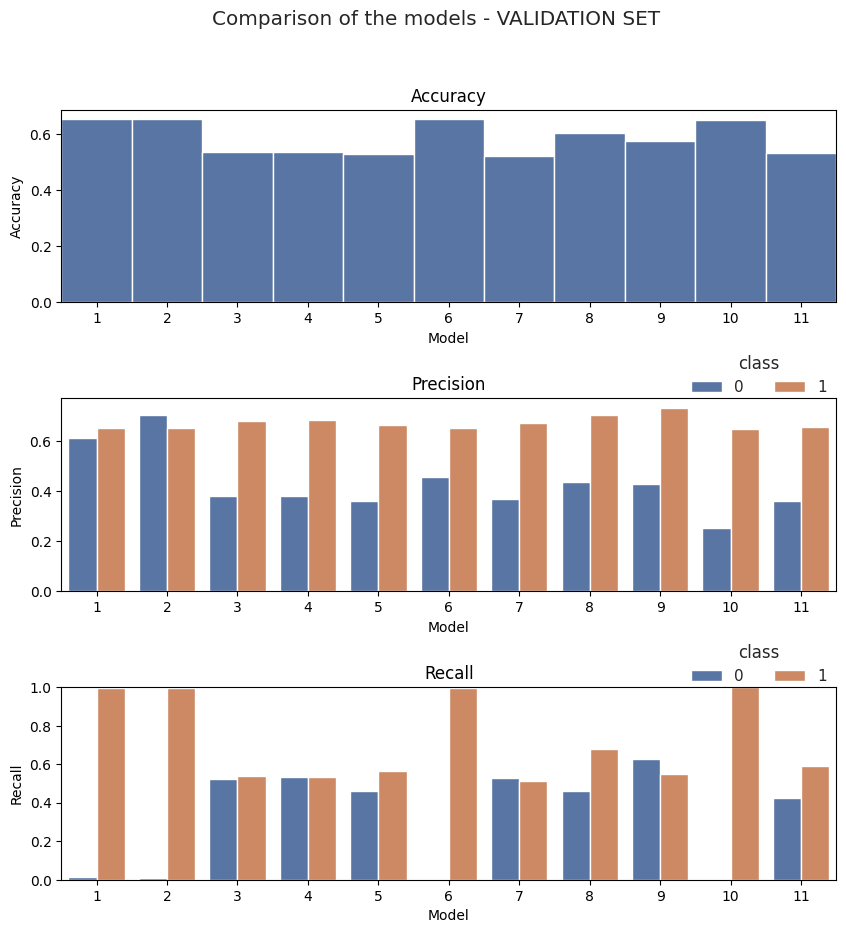

In [ ]:
fig = plt.figure(figsize = (10,10))
#fig, (ax1,ax2,ax3) = plt.subplots(3,1, sharex=True, sharey = True)
gs = GridSpec(3, 1)
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])
ax3 = plt.subplot(gs[2])
sns.set_theme()
acc = sns.barplot(data=model_accuracy, x='model', y='accuracy', ax = ax1, color=sns.color_palette()[0], width = 1)
prec = sns.barplot(data=model_comp, x='model', y='precision', hue = 'class', ax = ax2, width = 0.8)
rec = sns.barplot(data=model_comp, x='model', y='recall', hue = 'class', ax = ax3, width = 0.8)
sns.move_legend(prec, loc = 'upper center', bbox_to_anchor=(0.9,1.3), ncol = 2, frameon = False)
sns.move_legend(rec, loc = 'upper center', bbox_to_anchor=(0.9,1.3), ncol = 2, frameon = False)
plt.subplots_adjust(wspace=0.1, hspace = 0.5)
ax1.set_xlabel('Model')
ax2.set_xlabel('Model')
ax3.set_xlabel('Model')
ax1.set_ylabel('Accuracy')
ax2.set_ylabel('Precision')
ax3.set_ylabel('Recall')
ax1.set_title('Accuracy')
ax2.set_title('Precision')
ax3.set_title('Recall')
plt.ylim([0,1])
fig.suptitle('Comparison of the models - VALIDATION SET')
plt.show()

Tra gli 11 modelli confrontati sono stati scelti i migliori per ciascun tipo:
* SVM con kernel gaussiano e oversampling
* Bernoulli Naive-Bayes con oversampling
* KNN (K=6) senza oversampling
* Regressione logistica con oversampling

Questi sono stati confrontati utilizzando la precision-recall curve e la relativa area sottesa alla curva (AUC), considerata una metrica migliore rispetto alla ROC curve per dataset sbilanciati.

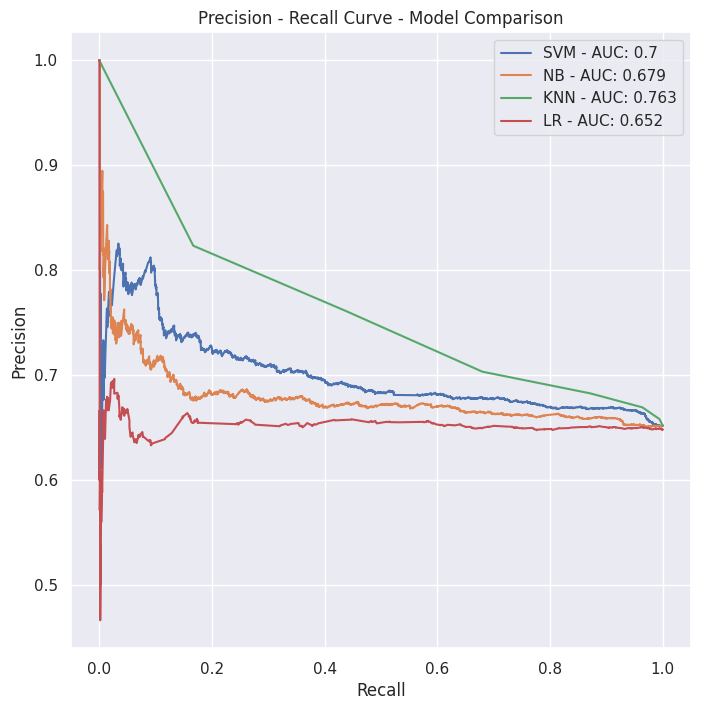

In [ ]:
pipe_svc_over.set_params(svc__kernel = 'rbf')
pipe_svc_over.set_params(svc__probability = True)
pipe_svc_over.fit(X_train_svm, y_train_svm)
pipe_knn.set_params(knn__n_neighbors = 6)
pipe_knn.fit(X_train_knn, y_train_knn)

models = [pipe_svc_over, pipe_bnb_over, pipe_knn, pipe_lr_over]

X = [X_val_svm,
     X_val_nb,
     X_val_knn,
     X_val_lr]

y = [y_val_svm,
     y_val_nb,
     y_val_knn,
     y_val_lr]

models_name = ['SVM','NB','KNN','LR']

plot_precision_recall_curve_comp(models = models,
                                 X = X,
                                 y = y,
                                 models_name = models_name)

### Modello Selezionato

Tenuto conto delle considerazioni precedenti sulle metriche da valutare con maggior attenzione per la scelta del modello e del risultato della comparazione delle curve precisione-recall, è stato scelto come modello definito il KNN con K=6 senza oversampling (modello 8).

Tale modello è stato riaddestrato sull'intero Training Set e i risultati delle metriche principali calcolate sul Test Set sono riportati di seguito.

In [ ]:
pipe_knn.set_params(knn__n_neighbors = 6)
pipe_knn.fit(X_train_knn, y_train_knn)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('y_n', OrdinalEncoder(),
                                                  ['FLAG_OWN_CAR',
                                                   'FLAG_OWN_REALTY']),
                                                 ('num', StandardScaler(),
                                                  ['CNT_CHILDREN',
                                                   'AMT_INCOME_TOTAL',
                                                   'DAYS_BIRTH',
                                                   'DAYS_EMPLOYED',
                                                   'CNT_FAM_MEMBERS']),
                                                 ('cat', OneHotEncoder(),
                                                  ['CODE_GENDER',
                                                   'NAME_INCOME_TYPE',
                                                   'NAME_EDUCATION_TYPE',
                                                   'NAME_FAMILY_STATUS',
                                                   'NAME_HOUSING_TYPE'])])),
                ('knn', KNeighborsClassifier(n_neighbors=6))])

In [ ]:
print(classification_report(y_test_knn, pipe_knn.predict(X_test_knn)))

              precision    recall  f1-score   support

           0       0.44      0.50      0.47      2394
           1       0.74      0.69      0.71      4898

    accuracy                           0.63      7292
   macro avg       0.59      0.59      0.59      7292
weighted avg       0.64      0.63      0.63      7292



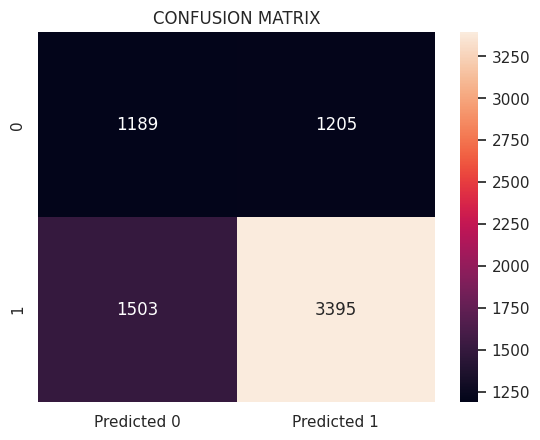

In [ ]:
plot_confusion_matrix(y_test_knn, pipe_knn.predict(X_test_knn))

### Conclusioni

Per la realizzazione di un classificatore in grado di fornire supporto nella decisione di rilasciare una carta di credito o meno a un potenziale cliente sono stati diversi tipi di modello, per ognuno di essi si è cercato di individuare i parametri che garantissero le migliori performance. Considerato lo scopo del classificatore, come detto in precedenza, le metriche che si è tentato di massimizzare e che sono state maggiormente considerate nella scelta del modello sono state recall della classe 1 e precision della classe 0.

Nonostante le numerose prove effettuate non è stato possibile individuare un classificatore con metriche soddisfacenti, come si può vedere dal classification report del modello finale. Infatti, questo mostra performance scarse sopratutto per quanto riguarda la classificazione delle osservazioni appartententi alla classe 0. Queste sono accompagnate da prestazioni al più discrete per quanto concerne la classe 1 che rendono tale classificatore nel complesso non particolarmente idoneo al suo scopo.

Per realizzare un classificatore performante, dunque, potrebbe essere necessario utilizzare metodi di machine learning più complessi che richiedono elevate prestazioni computazionali e fine-tuning oppure provare ad utilizzare un diverso dataset per il training dei modelli proposti.


Infine, di seguito, viene proposta una possibile previsione fornita all'operatore in cui, oltre alla classe dell'utente predetta, è indicata la percentuale associata così che l'operatore sia consapevole del grado di sicurezza con cui il modello ha classificato l'utente.

In [ ]:
test_obs = X_test_knn.iloc[1,:]

model_prediction(pipe_knn, test_obs)

L'utente ha una SCARSA AFFIDABILITA' CREDITIZIA con una probabilità del 100.0%
